In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from statsmodels.tsa.stattools import adfuller, kpss
#from statsmodels.tsa.stattools import acf, pacf
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [120]:
gold = pd.read_csv('ouro2.csv')
gold.columns = ['data', 'today_price']
gold['data']= pd.to_datetime(gold.data) #transform data into datetime
#Variação do preço do ouro
gold['next_week_price'] = gold.today_price.shift(1)
#gold['delta'] = gold.next_week_price - gold.today_price
#gold['s3'] = gold.delta.rolling(window=3).mean()
#gold['s10'] = gold.delta.rolling(window=10).mean()
gold['m3'] = gold.today_price.rolling(window=3).mean()
gold['m5'] = gold.today_price.rolling(window=3).mean()
gold['m7'] = gold.today_price.rolling(window=7).mean()
gold['m9'] = gold.today_price.rolling(window=9).mean()
gold['m12'] = gold.today_price.rolling(window=12).mean()
gold['m14'] = gold.today_price.rolling(window=14).mean()
gold['m17'] = gold.today_price.rolling(window=17).mean()
gold['m21'] = gold.today_price.rolling(window=21).mean()
gold['m28'] = gold.today_price.rolling(window=28).mean()
gold.dropna(inplace=True)
print("Número de linhas: {}\nNúmero de colunas: {}".format(gold.shape[0], gold.shape[1]))
gold.head()

Número de linhas: 1069
Número de colunas: 12


,data,today_price,next_week_price,m3,m5,m7,m9,m12,m14,m17,m21,m28
27,2020-06-12,1853.1,1898.2,1881.466667,1881.466667,1871.342857,1863.544444,1843.016667,1824.592857,1809.229412,1801.695238,1819.032143
28,2020-11-29,1849.0,1853.1,1866.766667,1866.766667,1869.085714,1867.011111,1852.600000,1833.500000,1816.211765,1805.466667,1818.353571
29,2020-11-22,1797.5,1849.0,1833.200000,1833.200000,1863.157143,1860.655556,1853.875000,1840.192857,1819.800000,1806.304762,1815.421429
30,2020-11-15,1888.2,1797.5,1844.900000,1844.900000,1869.271429,1863.255556,1858.883333,1851.207143,1828.176471,1811.352381,1815.285714
31,2020-08-11,1906.3,1888.2,1864.000000,1864.000000,1869.342857,1870.733333,1866.258333,1860.071429,1838.882353,1818.947619,1815.321429


In [121]:
gold.tail()

,data,today_price,next_week_price,m3,m5,m7,m9,m12,m14,m17,m21,m28
1091,2000-07-16,280.1,277.7,276.800000,276.800000,276.200000,275.444444,274.475000,274.092857,272.400000,271.604762,270.671429
1092,2000-09-07,281.1,280.1,279.633333,279.633333,276.785714,276.422222,275.458333,274.800000,273.376471,272.028571,271.325000
1093,2000-02-07,283.2,281.1,281.466667,281.466667,278.085714,277.522222,276.258333,275.571429,274.470588,272.719048,272.000000
1094,2000-06-25,290.1,283.2,284.800000,284.800000,279.985714,278.977778,277.783333,277.057143,275.982353,273.852381,272.935714
1095,2000-06-18,282.7,290.1,285.333333,285.333333,281.071429,279.933333,278.650000,277.707143,276.658824,274.661905,273.460714


### Normal series

<AxesSubplot:xlabel='today_price', ylabel='Count'>

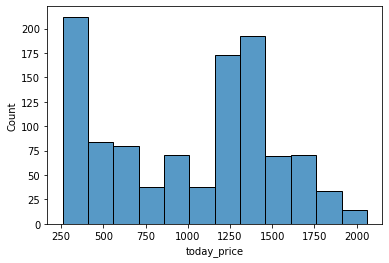

In [11]:
sns.histplot(gold.today_price)

<AxesSubplot:xlabel='data', ylabel='today_price'>

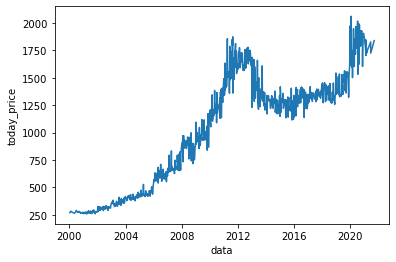

In [16]:
#print timeline graph
sns.lineplot(x=gold.data,y=gold.today_price)
#sns.lineplot(x=gold.data,y=gold.m7)
#sns.lineplot(x=gold.data,y=gold.m14)
#sns.lineplot(x=gold.data,y=gold.m21)

## Conjunto de treinamento

In [122]:
y_test = gold.next_week_price.tail(100) #Consideramos como treinamento os 100 ultimos dias
#X_test = gold.tail(100).drop(['data','today_price','next_week_price'],axis=1)
X_test = gold.filter(['m3','m5','m7'],axis=1).tail(100)
y_train = gold.next_week_price.head(-100)
#X_train = gold.head(-100).drop(['data','today_price','next_week_price'],axis=1)
X_train = gold.filter(['m3','m5','m7'],axis=1).head(-100)
print('Conjunto y de teste')
print("Número de linhas: {}".format(y_test.shape[0]))
y_test.head()

Conjunto y de teste
Número de linhas: 100


996     320.4
997     310.6
998     311.0
999     312.2
1000    311.6
Name: next_week_price, dtype: float64

In [123]:
print('Conjunto X de teste')
print("Número de linhas: {}\nNúmero de colunas: {}".format(X_test.shape[0], X_test.shape[1]))
X_test.head()

Conjunto X de teste
Número de linhas: 100
Número de colunas: 3


,m3,m5,m7
996,319.166667,319.166667,319.900000
997,314.000000,314.000000,319.542857
998,311.266667,311.266667,317.771429
999,311.600000,311.600000,316.700000
1000,308.700000,308.700000,313.514286


In [124]:
print('Conjunto y de treino')
print("Número de linhas: {}".format(y_train.shape[0]))
y_train.head()

Conjunto y de treino
Número de linhas: 969


27    1898.2
28    1853.1
29    1849.0
30    1797.5
31    1888.2
Name: next_week_price, dtype: float64

In [125]:
print('Conjunto X de treino')
print("Número de linhas: {}\nNúmero de colunas: {}".format(X_train.shape[0], X_train.shape[1]))
X_train.head()

Conjunto X de treino
Número de linhas: 969
Número de colunas: 3


,m3,m5,m7
27,1881.466667,1881.466667,1871.342857
28,1866.766667,1866.766667,1869.085714
29,1833.200000,1833.200000,1863.157143
30,1844.900000,1844.900000,1869.271429
31,1864.000000,1864.000000,1869.342857


## Random Forest Regressor

In [46]:
n_estimators_list = [50, 100, 1000]
max_features_list = [2, 4, 6]
final_rmse = np.inf
for n_estimators_value in n_estimators_list:
    for max_features_value in max_features_list:
        cross_val = cross_validate(
            RandomForestRegressor(n_estimators = n_estimators_value, max_features = max_features_value),
            X_train,
            np.ravel(y_train),
            scoring=('neg_root_mean_squared_error')
        )
        rmse_medio = np.sqrt(np.mean(np.absolute(cross_val['test_score'])))
        if rmse_medio < final_rmse:
            final_rmse = rmse_medio
            final_n_estimators = n_estimators_value
            final_max_features = max_features_value
print("Melhor RMSE = {}".format(final_rmse))
print("Valor de estimadores = {}".format(final_n_estimators))
print("Valor máximo de atributos = {}".format(final_max_features))

Melhor RMSE = 8.851626632352101
Valor de estimadores = 50
Valor máximo de atributos = 6


## Linear Regressor

In [126]:
cross_val = cross_validate(
    LinearRegression(),
    X_train,
    y_train,
    scoring=('neg_root_mean_squared_error')
)
rmse_medio =  np.sqrt(np.mean(np.absolute(cross_val['test_score'])))
print("RMSE = {}".format(rmse_medio))

RMSE = 3.572473365885337


In [127]:
linear = LinearRegression().fit(X_train, y_train)
print("Linear Regression model")
print("Gold Week Price (y) = %.2f * 3 Days Moving Average (x1) \
+ %.2f * 5 Days Moving Average (x2) \
+ %.2f * 7 Days Moving Average (x3) \
+ %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.coef_[2], linear.intercept_))

Linear Regression model
Gold Week Price (y) = -826305608841.15 * 3 Days Moving Average (x1) + 826305608842.23 * 5 Days Moving Average (x2) + -0.08 * 7 Days Moving Average (x3) + 1.21 (constant)


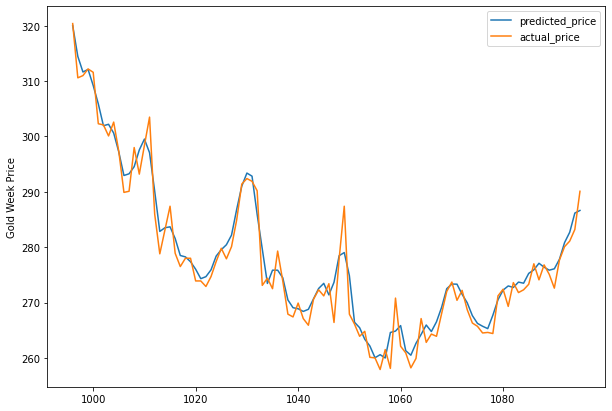

In [128]:
predicted_price = linear.predict(X_test)
d = {'actual_price': y_test,'predicted_price': predicted_price}
df = pd.DataFrame(data=d)
df['actual_var'] = df.actual_price.shift(1) - df.actual_price
df['actual_var_sign'] = np.sign(df.actual_var)
df['predicted_var'] = df.predicted_price.shift(1) - df.predicted_price
df['predicted_var_sign'] = df.predicted_var/abs(df.predicted_var)
df['correct_prediction'] = np.equal(df.actual_var_sign, df.predicted_var_sign)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(10, 7))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold Week Price")
plt.show()

In [129]:
df.head(30)
print("Número de linhas: {}".format(df.shape[0]))

Número de linhas: 100


In [130]:
r2_score = linear.score(X_test, y_test)*100
float("{0:.2f}".format(r2_score))

96.02

In [131]:
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))

Acertos: 64
